In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
import codebase

In [2]:
from codebase import volume_pipeline

In [3]:
res_shp = codebase.load_data.load_GRanD()

In [89]:
res_ref = codebase.load_data.load_formatted_usbr_data('mead')
res_ref_M = res_ref.resample('M').mean()
res_ref_elev = res_ref_M['Lake/Reservoir Elevation [ft]']
res_ref_M.columns

Index(['Lake/Reservoir Elevation [ft]', 'Lake/Reservoir Release - Total [af]',
       'Lake/Reservoir Release - Total [cfs]', 'Lake/Reservoir Storage [af]'],
      dtype='object', name='Variable')

In [7]:
# Volume pipeline with crs projection
dem_DA , fw_DA = volume_pipeline.create_aligned_DEM_CYGNSS_subsets('hoover',res_shp,epsg_code=54017)
fw_diff_DA = volume_pipeline.difference_over_time(fw_DA)
change_cond_DA = volume_pipeline.decide_expansion_or_shrinkage_vectorize(fw_diff_DA, input_core_dims = ['y','x'])
test_vol = volume_pipeline.calculate_rough_volume(dem_DA,fw_DA,fw_diff_DA,change_cond_DA,area_kwargs = {'input_core_dims' : [['y','x']], "vectorize": True})

In [88]:
# Grab height from volume pipeline
height_array = volume_pipeline.calculate_height_time_series_from_start_and_change_in_DEM(
        dem_DA, fw_DA, fw_diff_DA, change_cond_DA)
height_series = pd.Series(index = fw_diff_DA['time'], data = height_array)

In [91]:
height_series_match ,res_ref_elev_match = codebase.time_series_calcs.intersecting_timeframes(height_series,res_ref_elev)

In [136]:
mn = res_ref_elev_match.index[0].timestamp()*1e9
mx = res_ref_elev_match.index[-1].timestamp()*1e9
print(

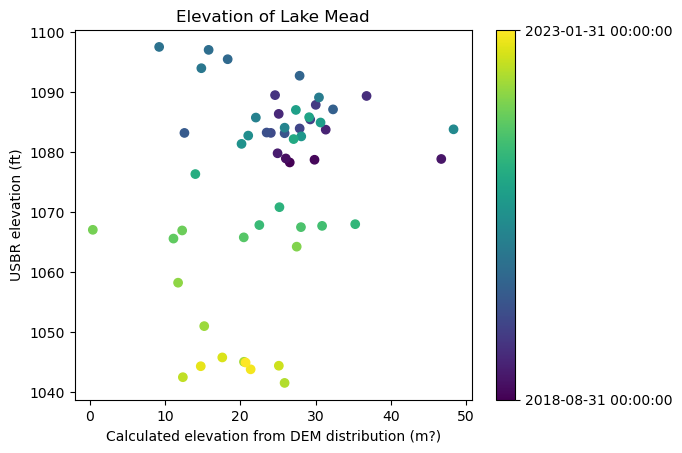

In [138]:
# Comparison of ref and calculated heights
plt.scatter(height_series_match ,res_ref_elev_match,c=res_ref_elev_match.index,vmin=mn, vmax=mx)
cbar = plt.colorbar()
cbar.set_ticks([mn,mx])
cbar.set_ticklabels([res_ref_elev_match.index[0],res_ref_elev_match.index[-1]])
plt.xlabel('Calculated elevation from DEM distribution (m?)')
plt.ylabel('USBR elevation (ft)')
plt.title('Elevation of Lake Mead');

Conclusion: DEM extraction is currently not a good match to reference elevation series.

<Axes: >

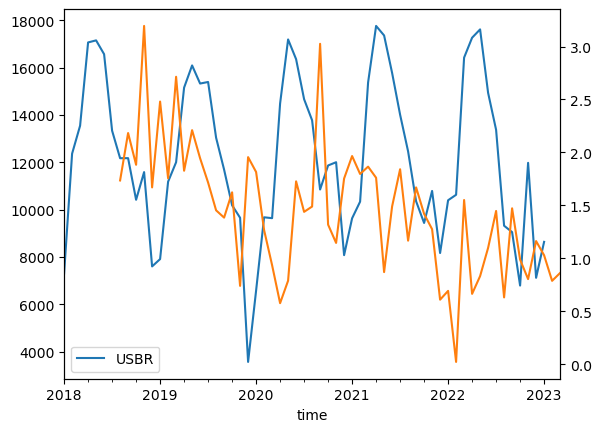

In [9]:
res_ref_M.plot(y='Lake/Reservoir Release - Total [cfs]', label='USBR')
test_vol.to_dataframe()['Watermask'].plot(label='Experimental',secondary_y= True)

In [ ]:
fw_diff_DA.isel(time=1).plot(cmap='RdBu')